In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
# train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                        #   batch_size=batch_size, identities_weight=0.02, identitity_weight_decay=0.96)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each


In [7]:
import optuna
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.metrics import auc

def objective(trial):
    trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
    encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

    id_weight = trial.suggest_int('identity_weight', 5, 300)
    decay= trial.suggest_int('decay',830, 999)

    id_weight/=1000
    decay/=1000
    y, Y = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=4,
                            batch_size=batch_size, identities_weight=id_weight, identitity_weight_decay=decay)
    
    prec, rec, _ = precision_recall_curve(y, Y)
    
    print('prc: ', auc(rec, prec))
    print('roc: ', roc_auc_score(y,Y))
    K = np.array(Y) > 0.5
    print('acc: ',accuracy_score(y,K))

    return auc(rec, prec)*10 + roc_auc_score(y,Y)*6 + accuracy_score(y,K)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Wyświetl najlepsze hiperparametry oraz wartość dokładności
print('Najlepsze hiperparametry:')
print(study.best_params)
print('Wartość średniej dokładności dla najlepszych hiperparametrów:')
print(study.best_value)

[I 2024-07-16 18:38:09,740] A new study created in memory with name: no-name-b19b411b-e0f9-4c40-a700-5589bcaf0cc3


train epoch 0/4 | batch 1704/1703 | loss 2.8971 | val loss 0.6939 | acc 0.4999 | f1 0.2645 | prec 0.1924 | recall 0.4230 | roc auc 0.4622 | pr auc 0.1923 | elapsed 29.93s
train epoch 1/4 | batch 1704/1703 | loss 1.9465 | val loss 0.5354 | acc 0.7739 | f1 0.4383 | prec 0.4643 | recall 0.4151 | roc auc 0.6889 | pr auc 0.4996 | elapsed 58.42s
train epoch 2/4 | batch 1704/1703 | loss 1.1332 | val loss 0.4875 | acc 0.7835 | f1 0.5405 | prec 0.4923 | recall 0.5991 | roc auc 0.7749 | pr auc 0.6128 | elapsed 59.24s
train epoch 3/4 | batch 1704/1703 | loss 0.7577 | val loss 0.5095 | acc 0.7779 | f1 0.5633 | prec 0.4839 | recall 0.6740 | roc auc 0.8057 | pr auc 0.6623 | elapsed 59.23s
train epoch 4/4 | batch 1704/1703 | loss 0.5115 | val loss 0.5480 | acc 0.7728 | f1 0.5700 | prec 0.4769 | recall 0.7083 | roc auc 0.8208 | pr auc 0.6895 | elapsed 57.19s


[I 2024-07-16 18:42:34,862] Trial 0 finished with value: 12.59296016840485 and parameters: {'identity_weight': 131, 'decay': 843}. Best is trial 0 with value: 12.59296016840485.


prc:  0.6895236439472991
roc:  0.8208149243763995
acc:  0.7728341826734614
train epoch 0/4 | batch 1704/1703 | loss 3.8299 | val loss 0.6364 | acc 0.7874 | f1 0.0000 | prec 0.0000 | recall 0.0000 | roc auc 0.4195 | pr auc 0.1857 | elapsed 28.38s
train epoch 1/4 | batch 1704/1703 | loss 2.6170 | val loss 0.5266 | acc 0.7841 | f1 0.4088 | prec 0.4892 | recall 0.3511 | roc auc 0.6677 | pr auc 0.4811 | elapsed 53.21s
train epoch 2/4 | batch 1704/1703 | loss 1.6567 | val loss 0.4857 | acc 0.7889 | f1 0.5366 | prec 0.5031 | recall 0.5750 | roc auc 0.7657 | pr auc 0.6012 | elapsed 54.49s
train epoch 3/4 | batch 1704/1703 | loss 1.2032 | val loss 0.5179 | acc 0.7666 | f1 0.5541 | prec 0.4665 | recall 0.6823 | roc auc 0.7990 | pr auc 0.6587 | elapsed 53.26s
train epoch 4/4 | batch 1704/1703 | loss 0.8283 | val loss 0.5925 | acc 0.7410 | f1 0.5535 | prec 0.4368 | recall 0.7551 | roc auc 0.8178 | pr auc 0.6880 | elapsed 53.92s
prc:  0.6879897731560276
roc:  0.8177763259417697
acc:  0.741003528028

[I 2024-07-16 18:46:39,097] Trial 1 finished with value: 12.527559215239119 and parameters: {'identity_weight': 148, 'decay': 997}. Best is trial 0 with value: 12.59296016840485.


train epoch 0/4 | batch 1704/1703 | loss 3.5758 | val loss 0.6550 | acc 0.7874 | f1 0.0000 | prec 0.0000 | recall 0.0000 | roc auc 0.4812 | pr auc 0.2227 | elapsed 26.43s
train epoch 1/4 | batch 1704/1703 | loss 2.4486 | val loss 0.5379 | acc 0.7736 | f1 0.3875 | prec 0.4561 | recall 0.3369 | roc auc 0.6497 | pr auc 0.4646 | elapsed 51.76s
train epoch 2/4 | batch 1704/1703 | loss 1.5257 | val loss 0.4665 | acc 0.8021 | f1 0.5406 | prec 0.5337 | recall 0.5477 | roc auc 0.7683 | pr auc 0.6088 | elapsed 51.52s
train epoch 3/4 | batch 1316/1703 | loss 1.1309 | elapsed 46.07s

In [ ]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner


train epoch 00/10 | batch 849/848 | loss 0.9192 | val loss 1.0175 | acc 0.6615 | f1 0.3885 | prec 0.3110 | recall 0.5176 | roc auc 0.6569 | pr auc 0.4395 | elapsed 6.87s
train epoch 01/10 | batch 849/848 | loss 0.8078 | val loss 0.8915 | acc 0.6858 | f1 0.4074 | prec 0.3349 | recall 0.5199 | roc auc 0.6882 | pr auc 0.4667 | elapsed 12.43s
train epoch 02/10 | batch 849/848 | loss 0.5894 | val loss 0.7984 | acc 0.7101 | f1 0.4380 | prec 0.3667 | recall 0.5438 | roc auc 0.7181 | pr auc 0.4971 | elapsed 12.06s
train epoch 03/10 | batch 849/848 | loss 0.4345 | val loss 0.7331 | acc 0.7303 | f1 0.4676 | prec 0.3964 | recall 0.5700 | roc auc 0.7431 | pr auc 0.5271 | elapsed 11.65s
train epoch 04/10 | batch 849/848 | loss 0.3303 | val loss 0.6878 | acc 0.7460 | f1 0.4938 | prec 0.4214 | recall 0.5963 | roc auc 0.7627 | pr auc 0.5545 | elapsed 12.59s
train epoch 05/10 | batch 849/848 | loss 0.2615 | val loss 0.6558 | acc 0.7585 | f1 0.5138 | prec 0.4416 | recall 0.6142 | roc auc 0.7780 | pr auc

In [ ]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240716T003732


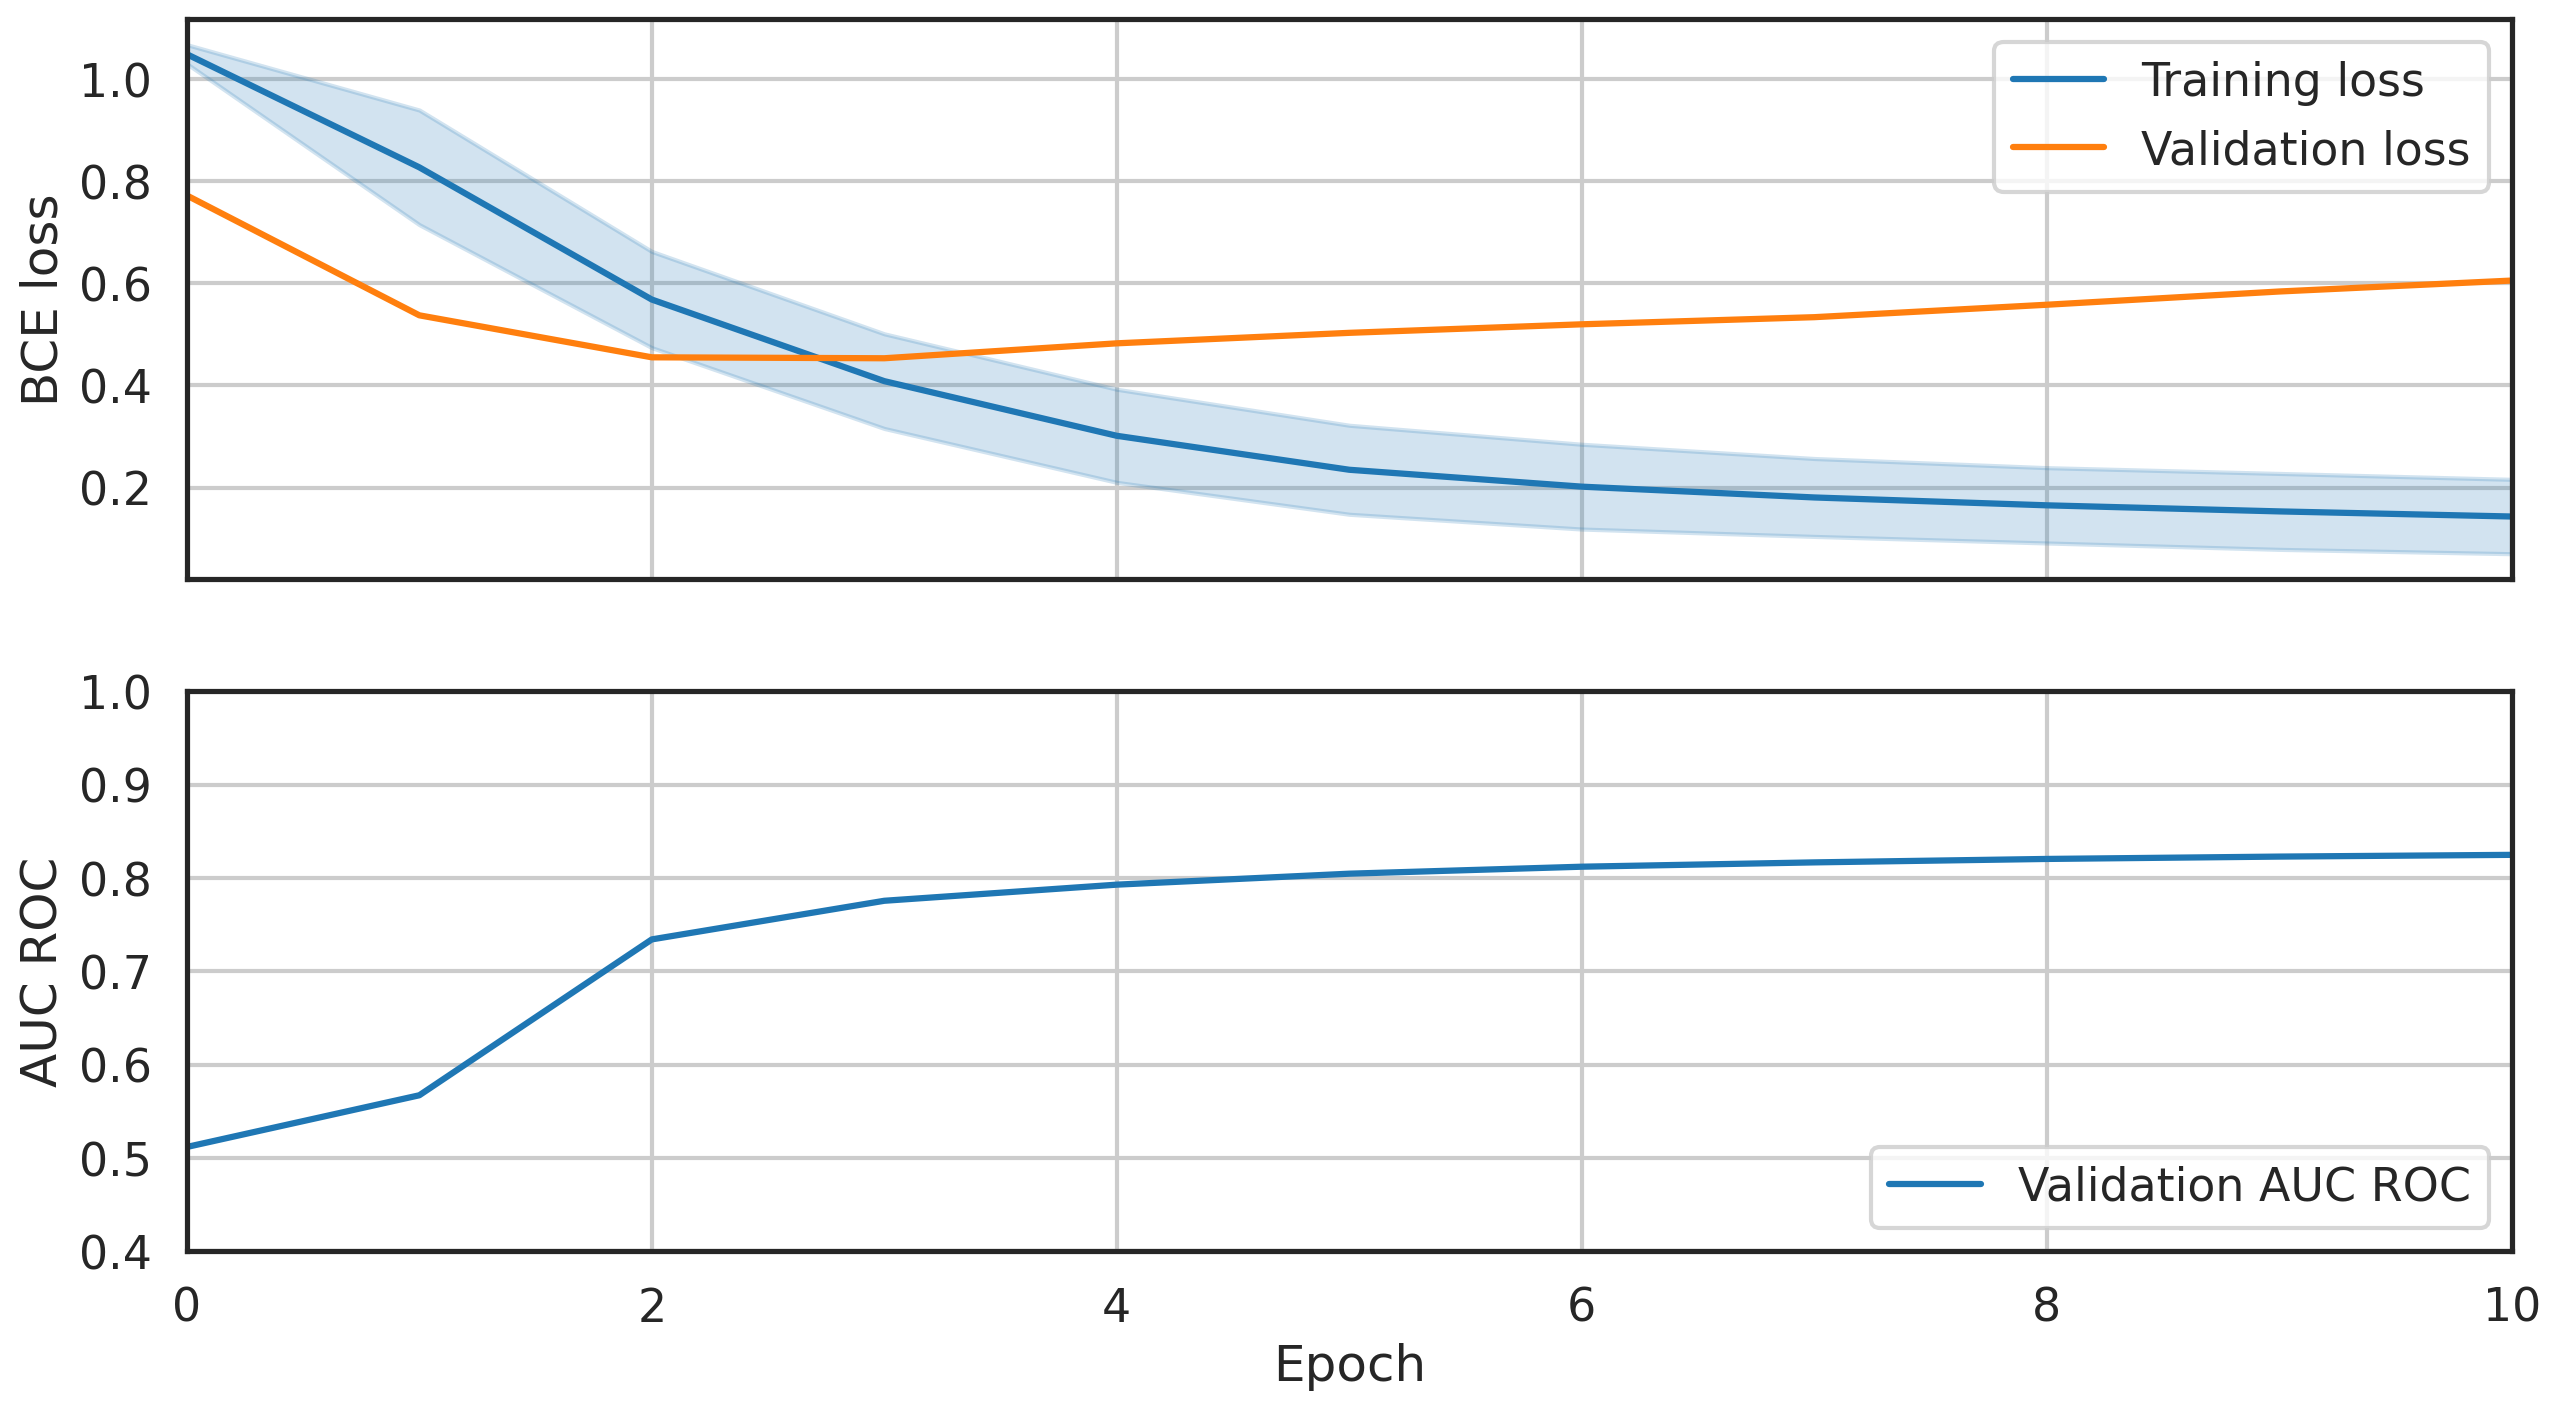

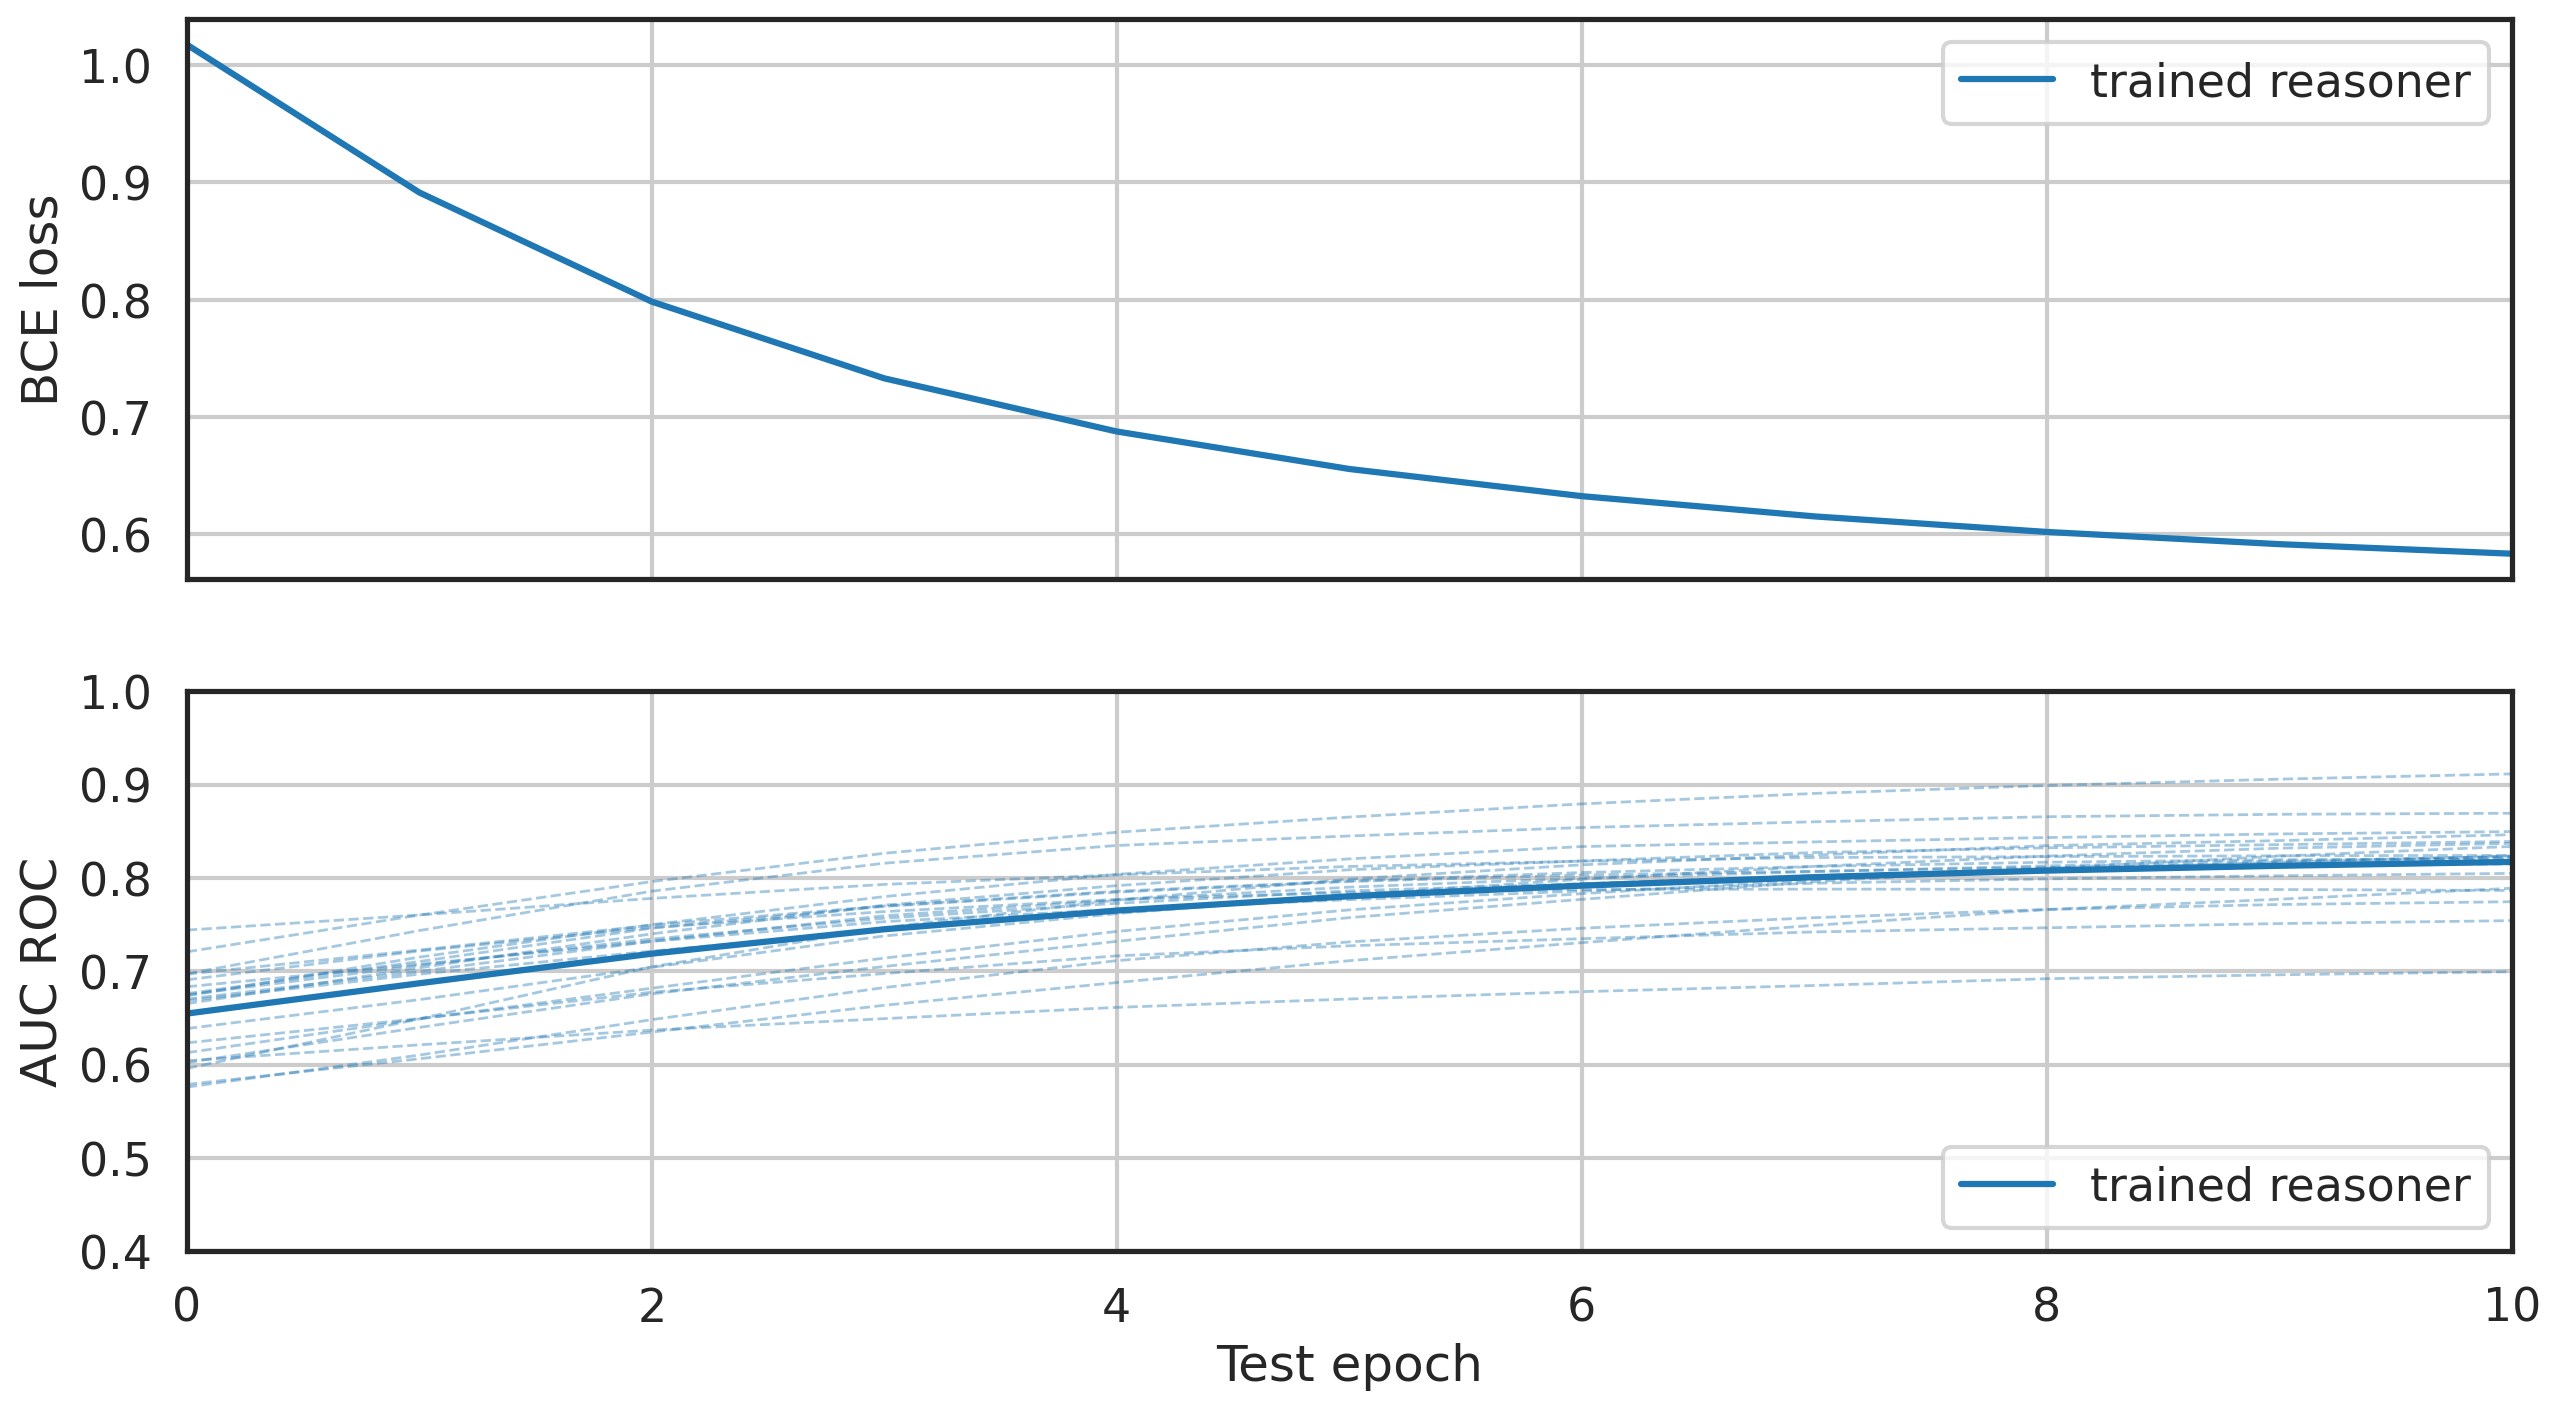

             mean       std     micro
acc      0.811998  0.049558  0.812364
prec     0.545603  0.104763  0.538983
recall   0.714946  0.082705  0.708767
f1       0.612655  0.080665  0.612323
auc_roc  0.842193  0.048688  0.840594
auc_pr   0.701378  0.094177  0.702268


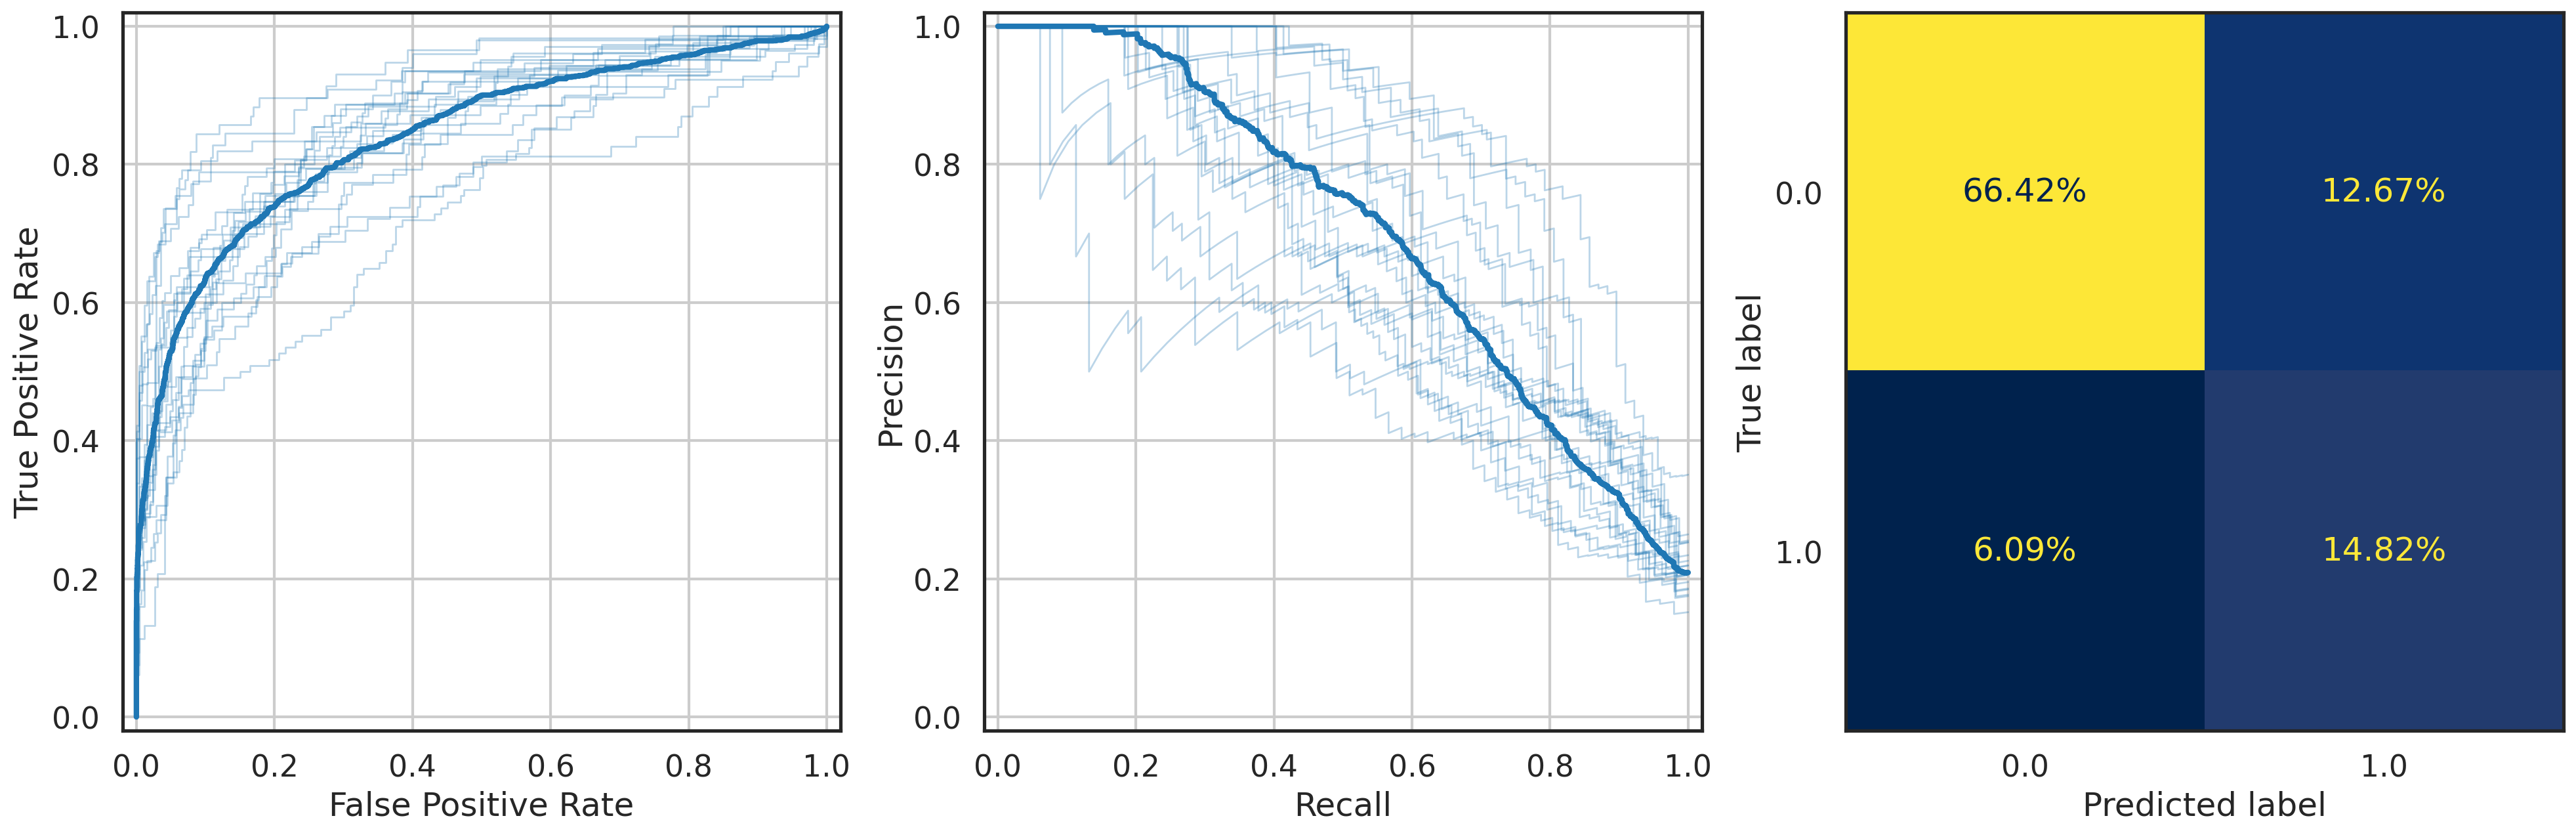

In [ ]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [ ]:
import random

In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([-0.0853,  0.0049,  0.0044,  0.1040, -0.2791, -0.0971, -0.0545, -0.2373,
         0.0291, -0.1781], grad_fn=<SelectBackward0>)
tensor([ 0.0283, -0.1301,  0.1543, -0.1816,  0.1470, -0.1504, -0.1508, -0.1428,
         0.1558,  0.1439], grad_fn=<AddBackward0>)
0.14532663188874723


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.8487,  0.3154, -0.0030, -0.4652,  0.9116, -0.0422,  0.2849,  0.1790,
        -0.4642, -0.3235], grad_fn=<SelectBackward0>)
tensor([ 0.5006,  0.4196, -0.2333, -0.1082,  0.1215,  0.4181,  0.3491,  0.4251,
        -0.4716, -0.1767], grad_fn=<AddBackward0>)
0.27251186221838


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.0393, -0.1274, -0.2614, -0.1177, -0.0585, -0.0664,  0.1144, -0.2802,
         0.1001,  0.0221], grad_fn=<SelectBackward0>)
tensor([-0.2182, -0.3193,  0.2273, -0.1661,  0.1478, -0.1756, -0.1602, -0.2823,
         0.2452,  0.2916], grad_fn=<AddBackward0>)
0.1793355718255043


In [ ]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.8487,  0.3154, -0.0030, -0.4652,  0.9116, -0.0422,  0.2849,  0.1790,
        -0.4642, -0.3235], grad_fn=<SelectBackward0>)


tensor([ 0.0291, -0.0860,  0.1372, -0.2300,  0.1739, -0.1169, -0.1536, -0.1260,
         0.1137,  0.0972], grad_fn=<AddBackward0>)
0.36536308377981186


In [ ]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.8487,  0.3154, -0.0030, -0.4652,  0.9116, -0.0422,  0.2849,  0.1790,
        -0.4642, -0.3235], grad_fn=<SelectBackward0>)
tensor([ 0.8487,  0.3152, -0.0028, -0.4649,  0.9116, -0.0422,  0.2849,  0.1790,
        -0.4640, -0.3235], grad_fn=<SqueezeBackward3>)
tensor(9.1464e-05, grad_fn=<L1LossBackward0>)


In [ ]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.0286, -0.2194,  0.0205,  0.4425,  0.1463,  0.3542,  1.5009,  0.0721,
        -0.2669,  0.2835], grad_fn=<SelectBackward0>)
tensor([ 0.0288, -0.2195,  0.0202,  0.4425,  0.1462,  0.3544,  1.5013,  0.0722,
        -0.2671,  0.2835], grad_fn=<SqueezeBackward3>)
tensor(0.0001, grad_fn=<L1LossBackward0>)


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.1326, -0.0631,  0.0128, -0.1697,  0.1839,  0.0128, -0.0778, -0.0954,
        -0.0058,  0.0982], grad_fn=<AddBackward0>)
tensor([ 0.0459,  0.0285,  0.0899, -0.2081,  0.1915, -0.0053, -0.0852, -0.0492,
        -0.0394,  0.0515], grad_fn=<AddBackward0>)
0.03770795250311494


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.0574,  0.0155,  0.0813, -0.1991,  0.1782,  0.0296, -0.0436,  0.0211,
        -0.0320,  0.0349], grad_fn=<AddBackward0>)
tensor([ 0.1004, -0.0202,  0.0521, -0.2140,  0.1707, -0.0263, -0.0697,  0.0596,
        -0.1071,  0.0224], grad_fn=<AddBackward0>)
0.029833172308281065


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.1733,  0.2138, -0.0319, -0.2493,  0.1992,  0.0884,  0.0452,  0.0611,
        -0.2770,  0.0685], grad_fn=<SelectBackward0>)
tensor([ 0.0836,  0.1108,  0.0115, -0.2417,  0.0640,  0.0104,  0.0819,  0.1758,
        -0.1955, -0.0690], grad_fn=<AddBackward0>)
0.1997889805585146


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9999014347791672


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

1.0
